# Mantenimiento de Montacargas

Predicción de tipo de intervención (mantenimiento), al ingresar los campos máquina, fecha (año, mes, día) y lugar de operación

In [1]:
#Para eliminar tíldes
!pip install unidecode

In [2]:
!pip install category_encoders

In [3]:
#Se importan las librerías necesarias para el proyecto, para manipulación, procesamiento y análisis de datos

import pandas as pd
import re
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Preparación de los Datos
Se carga el reporte de mantenimiento y se crea una copia.

Se realizan diferentes consultas para mostrar los datos, estructura, cantidad de campos nulos




In [4]:
#Se carga el reporte y se realiza una copia
data = pd.read_excel('/content/REPORTES MANTENIMIENTO_M1.xlsx')
datos_mtto = data.copy()
datos_pruebas = data.copy()
datos_mtto

,MAQUINA,FECHA,CODIGO DE REPORTE,LUGAR DE OPERACIÓN,TÉCNICO A CARGO,TIPO DE INTERVENCION,HORÓMETRO,MOTIVO DE INTERVENCION,DESCRIPCIÓN DEL MANTENIMIENTO,HORA DE PARO,HORA DE ENTREGA,HORA INICIO TRABAJO,HORA FIN TRABAJO,TIEMPO DE TRABAJO
0,MC 115,2024-12-05,26910,01-00 - PAPELSA SA,FABIAN,GENERAL,6020.0,Terminar de armar MC,Se termina de armar MC se adiciona refrigerant...,NaN,NaT,2024-12-04 22:00:00,2024-12-05 05:45:00,465.0
1,ROLL CLAMP 2,2024-12-05,26909,01-00 - PAPELSA SA,FABIAN,AVERIA,0.0,Fuga hidráulica,Se recibe reporte de operario por fuga hidrául...,NaN,NaT,2024-12-05 05:00:00,2024-12-05 06:00:00,60.0
2,B84,2024-12-05,26913,03-00 - SOFASA SMYM LOGISTICA S.A.S - PERSONAL...,OLGER,PLAN DE ACCION,10041.0,Plan de acción,Se realiza plan de acción se limpian mangueras...,NaN,NaT,2024-12-05 06:00:00,2024-12-05 10:00:00,240.0
3,ROLL CLAMP 2,2024-12-05,26914,01-00 - PAPELSA SA,ANDRES ALBERTO,AVERIA,0.0,Desmonte de motor de giro,Se realiza el desmonte del motor de giro del r...,0,NaT,2024-12-05 06:00:00,2024-12-05 09:30:00,210.0
4,MC 115,2024-12-05,26915,01-00 - PAPELSA SA,ANDRES ALBERTO,GENERAL,0.0,Máquina no prende,Se realiza inspección de la máquina - ya que n...,NaN,NaT,2024-12-05 10:00:00,2024-12-05 14:00:00,240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25751,MC 110,2018-01-15,938,01-00 - PAPELSA SA,CESAR AUGUSTO,AVERIA,NaN,NaN,Alambre enredado en el cardán. Se bloquea - s...,NaN,NaT,NaT,NaT,NaN
25752,MC 43,2018-01-04,4,02-00 - PROCTER & GAMBLE COLOMBIA LTDA.,CESAR AUGUSTO,AVERIA,NaN,NaN,.,NaN,NaT,NaT,NaT,NaN
25753,MC 49,2017-09-29,186,02-00 - PROCTER & GAMBLE COLOMBIA LTDA.,DAVID SANTIAGO,AVERIA,23075.0,NaN,Cambio cadenas cilindro central,NaN,NaT,NaT,NaT,NaN
25754,MC 41,NaT,3536,- SOFASA,JOSE ALIRIO,DEFECTO,15887.0,NaN,se completa aceite de motor y se lubrica caden...,20/01/2020 8:00,2020-01-20 09:00:00,NaT,NaT,NaN


In [5]:
#Se consulta el tipo de información que tiene los datos_mtto
datos_mtto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25756 entries, 0 to 25755
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   MAQUINA                        25532 non-null  object        
 1   FECHA                          25754 non-null  datetime64[ns]
 2   CODIGO DE REPORTE              25756 non-null  int64         
 3   LUGAR DE OPERACIÓN             25753 non-null  object        
 4   TÉCNICO A CARGO                25654 non-null  object        
 5   TIPO DE INTERVENCION           25756 non-null  object        
 6   HORÓMETRO                      25089 non-null  float64       
 7   MOTIVO DE INTERVENCION         17923 non-null  object        
 8   DESCRIPCIÓN DEL MANTENIMIENTO  25756 non-null  object        
 9   HORA DE PARO                   24073 non-null  object        
 10  HORA DE ENTREGA                24039 non-null  datetime64[ns]
 11  HORA INICIO TRA

In [6]:
#Se consultan el total de datos nulos por campo
datos_mtto.isnull().sum()

,0
MAQUINA,224
FECHA,2
CODIGO DE REPORTE,0
LUGAR DE OPERACIÓN,3
TÉCNICO A CARGO,102
TIPO DE INTERVENCION,0
HORÓMETRO,667
MOTIVO DE INTERVENCION,7833
DESCRIPCIÓN DEL MANTENIMIENTO,0
HORA DE PARO,1683


In [7]:
#Se consulta por campo el porcentaje de nulos
datos_mtto.isnull().mean()*100

,0
MAQUINA,0.869700
FECHA,0.007765
CODIGO DE REPORTE,0.000000
LUGAR DE OPERACIÓN,0.011648
TÉCNICO A CARGO,0.396024
TIPO DE INTERVENCION,0.000000
HORÓMETRO,2.589688
MOTIVO DE INTERVENCION,30.412331
DESCRIPCIÓN DEL MANTENIMIENTO,0.000000
HORA DE PARO,6.534400


Teniendo en cuenta el porcentaje de datos nulos


*   Se realiza limpieza de datos, eliminando los campos que no son necesarios y registros duplicados
*   Se imputan campos nulos
*   Se eliminan tildes y el texto se estandariza a mayúscula



In [8]:
#Eliminar las columnas que no se requieren
datos_mtto = datos_mtto.drop('TIEMPO DE TRABAJO', axis=1)
datos_mtto = datos_mtto.drop('HORA INICIO TRABAJO', axis=1)
datos_mtto = datos_mtto.drop('HORA FIN TRABAJO', axis=1)
datos_mtto = datos_mtto.drop('HORA DE ENTREGA', axis=1)
datos_mtto = datos_mtto.drop('HORA DE PARO', axis=1)
datos_mtto = datos_mtto.drop('CODIGO DE REPORTE', axis=1)
datos_mtto = datos_mtto.drop('MOTIVO DE INTERVENCION', axis=1)

#Eliminar los registros nulos de los campos
datos_mtto = datos_mtto.dropna(subset=['MAQUINA'])

#Imputar los campos con la moda
datos_mtto['FECHA'].fillna(value=datos_mtto['FECHA'].mode()[0], inplace=True)
datos_mtto['LUGAR DE OPERACIÓN'].fillna(value=datos_mtto['LUGAR DE OPERACIÓN'].mode()[0], inplace=True)

#Eliminar los registros nulos de los campos
datos_mtto = datos_mtto.dropna(subset=['HORÓMETRO'])
datos_mtto = datos_mtto.dropna(subset=['TÉCNICO A CARGO'])

<ipython-input-8-799bd413e893>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos_mtto['FECHA'].fillna(value=datos_mtto['FECHA'].mode()[0], inplace=True)
<ipython-input-8-799bd413e893>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

In [9]:
#Se verifica que no se presenten campos nulos
datos_mtto.isnull().sum()

,0
MAQUINA,0
FECHA,0
LUGAR DE OPERACIÓN,0
TÉCNICO A CARGO,0
TIPO DE INTERVENCION,0
HORÓMETRO,0
DESCRIPCIÓN DEL MANTENIMIENTO,0


In [10]:
#Consulta la cantidad de registros duplicados
datos_mtto.duplicated().sum()

128

In [11]:
#Elimina los datos duplicados
datos_mtto.drop_duplicates(inplace=True)

In [12]:
#Consulta que no se presenten registros duplicados
datos_mtto.duplicated().sum()

0

In [13]:
#Funcion para cambiar los datos a mayúscula
def texto_mayuscula(texto):
    texto = str(texto).upper()
    return texto

datos_mtto['DESCRIPCIÓN DEL MANTENIMIENTO'] = datos_mtto['DESCRIPCIÓN DEL MANTENIMIENTO'].apply(texto_mayuscula)


#Función para eliminar las tildes de los campos
def eliminar_tildes(texto):
    parts = re.split(r'([ñÑ])', texto)
    texto_sin_tildes = ''.join([(unidecode(x) if x != 'ñ' and x != 'Ñ' else x) for x in parts])
    return texto_sin_tildes

datos_mtto['DESCRIPCIÓN DEL MANTENIMIENTO'] = datos_mtto['DESCRIPCIÓN DEL MANTENIMIENTO'].apply(eliminar_tildes)

# Ingeniería de Modelos

Para realizar el modelo, los campos que se requieren son categóricos, en ese caso se debe códificar en valores númericos

In [14]:
#Se codifica 'TIPO DE INTERVENCION' en valores numéricos
encoder_y = LabelEncoder()
datos_mtto['TIPO DE INTERVENCION'] = encoder_y.fit_transform(datos_mtto['TIPO DE INTERVENCION'])

In [15]:
#Se consulta encoder_y
encoder_y.inverse_transform(datos_mtto['TIPO DE INTERVENCION'].unique())

array(['GENERAL', 'AVERIA', 'PLAN DE ACCION', 'DEFECTO',
       'M1 - M2 - M3 - M4', 'INSPECCION'], dtype=object)

In [16]:
#Se consulta en el campo 'TIPO DE INTERVENCION' la cantidad de registros que se presentan por tipo, para validar el balance
datos_mtto['TIPO DE INTERVENCION'].value_counts()

,count
TIPO DE INTERVENCION,
1,6906
2,5899
0,5800
4,3915
3,1745
5,482


In [17]:
#Se divide en características y variable objetivo
X = datos_mtto[['MAQUINA', 'FECHA', 'LUGAR DE OPERACIÓN']]
y = datos_mtto['TIPO DE INTERVENCION']

In [18]:
#Se consulta la fecha y se debe convertir en características numéricas
datos_mtto['FECHA']

,FECHA
0,2024-12-05
1,2024-12-05
2,2024-12-05
3,2024-12-05
4,2024-12-05
...,...
25749,2018-02-23
25750,2018-02-04
25753,2017-09-29
25754,2023-02-24


In [19]:
# Convierte el campo fecha a características numéricas (día, mes, año)
X['AÑO'] = X['FECHA'].dt.year
X['MES'] = X['FECHA'].dt.month
X['DÍA'] = X['FECHA'].dt.day

# Elimina el campo fecha
X = X.drop(columns=['FECHA'])
X

<ipython-input-19-7321376993d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['AÑO'] = X['FECHA'].dt.year
<ipython-input-19-7321376993d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['MES'] = X['FECHA'].dt.month
<ipython-input-19-7321376993d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,MAQUINA,LUGAR DE OPERACIÓN,AÑO,MES,DÍA
0,MC 115,01-00 - PAPELSA SA,2024,12,5
1,ROLL CLAMP 2,01-00 - PAPELSA SA,2024,12,5
2,B84,03-00 - SOFASA SMYM LOGISTICA S.A.S - PERSONAL...,2024,12,5
3,ROLL CLAMP 2,01-00 - PAPELSA SA,2024,12,5
4,MC 115,01-00 - PAPELSA SA,2024,12,5
...,...,...,...,...,...
25749,EE 33,02-00 - PROCTER & GAMBLE COLOMBIA LTDA.,2018,2,23
25750,EE 33,02-00 - PROCTER & GAMBLE COLOMBIA LTDA.,2018,2,4
25753,MC 49,02-00 - PROCTER & GAMBLE COLOMBIA LTDA.,2017,9,29
25754,MC 41,- SOFASA,2023,2,24


In [20]:
#Se consulta el tipo de datos de X
X.dtypes

,0
MAQUINA,object
LUGAR DE OPERACIÓN,object
AÑO,int32
MES,int32
DÍA,int32


In [21]:
#Se consulta en el campo 'LUGAR DE OPERACIÓN' la cantidad de registros que se presentan por lugar, para validar el balance
X['LUGAR DE OPERACIÓN'].value_counts()

,count
LUGAR DE OPERACIÓN,
01-00 - PAPELSA SA,11654
02-00 - PROCTER & GAMBLE COLOMBIA LTDA.,4839
- SOFASA,1450
11-00 - COLHILADOS,1107
22-00 - TALLER,1040
...,...
64-00 - ALPOPULAR S.A,1
08-00 - RENAULT SOFASA S.A.S - DECAPADO,1
45-00 - LA TIENDA DEL TRIPLEX S.A.S,1


In [22]:
#Se codifica 'MAQUINA' y 'LUGAR DE OPERACIÓN' en valores numéricos
encoder = ce.TargetEncoder(cols=['MAQUINA', 'LUGAR DE OPERACIÓN'], smoothing=0.5)
X_encoded = encoder.fit_transform(X, y)
X_encoded

,MAQUINA,LUGAR DE OPERACIÓN,AÑO,MES,DÍA
0,1.600542,1.458984,2024,12,5
1,0.933333,1.458984,2024,12,5
2,1.697541,2.221142,2024,12,5
3,0.933333,1.458984,2024,12,5
4,1.600542,1.458984,2024,12,5
...,...,...,...,...,...
25749,1.982759,2.094028,2018,2,23
25750,1.982759,2.094028,2018,2,4
25753,1.475610,2.094028,2017,9,29
25754,1.677632,1.649655,2023,2,24


In [23]:
#Se valida que la cantidad de filas de X_encoded y y sean iguales
X_encoded.shape

(24747, 5)

In [24]:
y.shape

(24747,)

In [25]:
#Se divide en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [26]:
#Se realiza balanceo usando SMOTEEIN
smote_enn = SMOTEENN(sampling_strategy='all')
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

#Se muestra la distribución antes y después del balanceo
print("Antes del balanceo:", np.bincount(y_train))
print("Después del balanceo:", np.bincount(y_resampled))


Antes del balanceo: [4064 4863 4164 1206 2690  335]
Después del balanceo: [ 641  390  901 2414 1414 3830]


# Comparación de Modelos

**Modelo Random Forest Classifier**

In [27]:
#Crear el modelo Random Forest Classifier
modelo_rfc = RandomForestClassifier(class_weight='balanced')

#Entrenar el modelo
modelo_rfc.fit(X_resampled, y_resampled)

#Realizar predicciones en el conjunto de prueba
y_prediccion = modelo_rfc.predict(X_test)

#Evaluar el modelo
accuracy = accuracy_score(y_test, y_prediccion)
print(f"\nPrecisión del modelo: {accuracy:.2f}")

#Calcular las métricas de evaluación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_prediccion))

#Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_prediccion)
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_prediccion))


Precisión del modelo: 0.38

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.47      0.29      0.36      1736
           1       0.50      0.25      0.34      2043
           2       0.49      0.51      0.50      1735
           3       0.25      0.65      0.37       539
           4       0.41      0.41      0.41      1225
           5       0.10      0.65      0.17       147

    accuracy                           0.38      7425
   macro avg       0.37      0.46      0.36      7425
weighted avg       0.45      0.38      0.39      7425


Matriz de Confusión:
[[500 242 314 294 231 155]
 [213 520 330 438 315 227]
 [189 134 879 133 149 251]
 [ 33  32  53 351  23  47]
 [123  99 177 158 501 167]
 [  0   3  30   6  13  95]]


**Modelo Naive Bayes Multinomial**

In [28]:
#Crear el modelo Naive Bayes Multinomial
modelo_mNB = MultinomialNB()

#Entrenar el modelo
modelo_mNB.fit(X_resampled, y_resampled)

#Realizar predicciones en el conjunto de prueba
y_prediccion = modelo_mNB.predict(X_test)

#Evaluar el modelo
accuracy = accuracy_score(y_test, y_prediccion)
print(f"\nPrecisión del modelo: {accuracy:.2f}")

#Calcular las métricas de evaluación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_prediccion))

#Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_prediccion)
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_prediccion))



Precisión del modelo: 0.02

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1736
           1       0.00      0.00      0.00      2043
           2       0.00      0.00      0.00      1735
           3       0.00      0.00      0.00       539
           4       1.00      0.00      0.00      1225
           5       0.02      1.00      0.04       147

    accuracy                           0.02      7425
   macro avg       0.17      0.17      0.01      7425
weighted avg       0.17      0.02      0.00      7425


Matriz de Confusión:
[[   0    0    0    0    0 1736]
 [   0    0    0    0    0 2043]
 [   0    0    0    0    0 1735]
 [   0    0    0    0    0  539]
 [   0    0    0    0    2 1223]
 [   0    0    0    0    0  147]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Modelo Decision Tree Classifier**

In [29]:
#Crear el modelo Árbol de Decisión
modelo_dtc = DecisionTreeClassifier(random_state=42)

#Entrenar el modelo
modelo_dtc.fit(X_resampled, y_resampled)

#Realizar predicciones en el conjunto de prueba
y_prediccion = modelo_dtc.predict(X_test)

#Evaluar el modelo
accuracy = accuracy_score(y_test, y_prediccion)
print(f"\nPrecisión del modelo: {accuracy:.2f}")

#Calcular las métricas de evaluación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_prediccion))

#Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_prediccion)
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_prediccion))


Precisión del modelo: 0.35

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.44      0.26      0.33      1736
           1       0.46      0.25      0.32      2043
           2       0.48      0.45      0.46      1735
           3       0.23      0.60      0.33       539
           4       0.37      0.38      0.37      1225
           5       0.09      0.57      0.15       147

    accuracy                           0.35      7425
   macro avg       0.34      0.42      0.33      7425
weighted avg       0.42      0.35      0.36      7425


Matriz de Confusión:
[[452 286 280 297 252 169]
 [217 508 322 410 341 245]
 [185 128 779 203 161 279]
 [ 36  42  60 323  34  44]
 [135 129 167 169 467 158]
 [  1   7  27  11  17  84]]


**Modelo XGBoost Classifier**

In [30]:
#Crear el modelo Árbol de Decisión
modelo_xgb = XGBClassifier(
    objective='multi:softmax',  # Para clasificación multiclase
    num_class=len(np.unique(y)),  # Número de clases
    scale_pos_weight=10,  # Peso para clases desbalanceadas (ajustar si es necesario)
    eval_metric='mlogloss',  # Métrica para monitorear durante el entrenamiento
    random_state=42
)

#Entrenar el modelo
modelo_xgb.fit(X_resampled, y_resampled)

#Realizar predicciones en el conjunto de prueba
y_prediccion = modelo_xgb.predict(X_test)

#Evaluar el modelo
accuracy = accuracy_score(y_test, y_prediccion)
print(f"\nPrecisión del modelo: {accuracy:.2f}")

#Calcular las métricas de evaluación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_prediccion))

#Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_prediccion)
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_prediccion))

#Balance Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_prediccion)
print(f"\nBalanced Accuracy: {balanced_acc:.4f}")

#ROC-AUC para clasificación multiclase
#Calcula probabilidades de las clases para evaluar ROC-AUC
y_pred_proba = modelo_xgb.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Calcular curva ROC para clasificación multiclase
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:49:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)



Precisión del modelo: 0.36

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.43      0.27      0.33      1736
           1       0.50      0.23      0.32      2043
           2       0.48      0.48      0.48      1735
           3       0.24      0.64      0.35       539
           4       0.40      0.41      0.40      1225
           5       0.10      0.65      0.17       147

    accuracy                           0.36      7425
   macro avg       0.36      0.45      0.34      7425
weighted avg       0.43      0.36      0.37      7425


Matriz de Confusión:
[[461 222 296 333 261 163]
 [234 477 339 451 312 230]
 [206 124 831 151 148 275]
 [ 32  34  67 345  23  38]
 [133  93 183 165 497 154]
 [  0   7  30   6   9  95]]

Balanced Accuracy: 0.4450
ROC-AUC Score: 0.7231


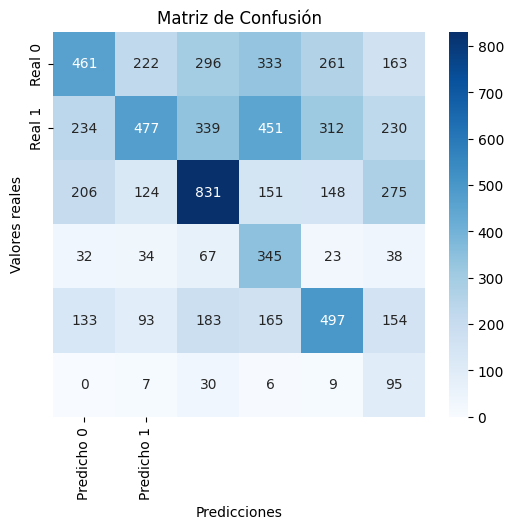

In [31]:
#Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho 0', 'Predicho 1'], yticklabels=['Real 0', 'Real 1'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.show()

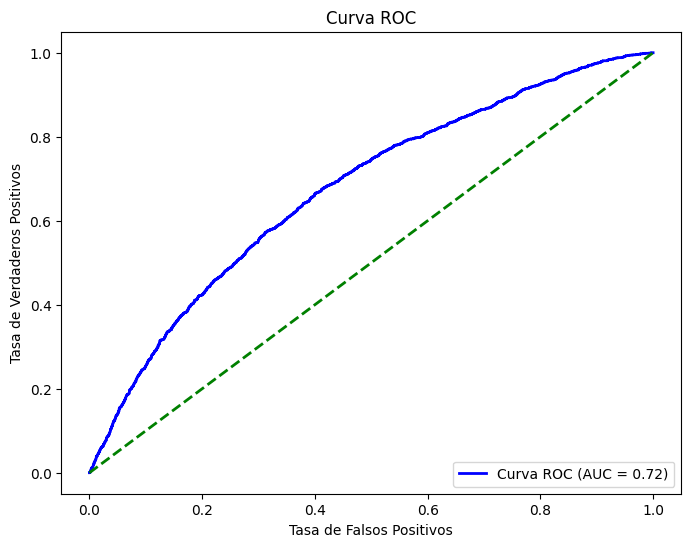

In [32]:
#Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

In [33]:
nuevos_datos = ['MC 115', '01-00 - PAPELSA SA',	2024,12,5]

nuevos_datos = pd.DataFrame([nuevos_datos], columns=['MAQUINA', 'LUGAR DE OPERACIÓN', 'AÑO', 'MES', 'DÍA'])

nuevos_datos_encoded = encoder.transform(nuevos_datos)
prediccion = modelo_xgb.predict(nuevos_datos_encoded)
print("Predicción:", prediccion)

Predicción: [2]


In [34]:
resultado_prediccion = encoder_y.inverse_transform(prediccion)
print("Resultado de la predicción")
print("Tipo de intervención:", resultado_prediccion)

Resultado de la predicción
Tipo de intervención: ['GENERAL']


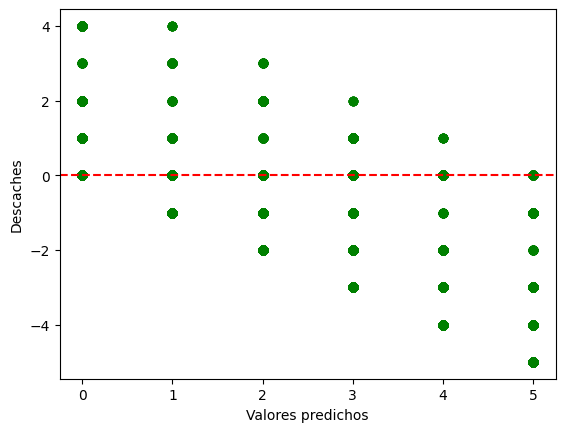

In [35]:
#Gráficar
descaches = y_test - y_prediccion

plt.scatter(y_prediccion, descaches, color='green', )
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valores predichos')
plt.ylabel('Descaches')
plt.show()

In [36]:
#Guardar el modelo entrenado
import pickle
with open('modelo_xgb.pkl', 'wb') as archivo:
    pickle.dump(modelo_xgb, archivo)

In [37]:
#Guardar el encoder
with open('encoder.pkl', 'wb') as archivo:
    pickle.dump(encoder, archivo)